In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 265 ms (started: 2022-09-15 22:56:22 -07:00)


Images of Brendan Frey’s face at a (20 x 28 resolution), as far as I know originating from a page belonging to [Saul Roweis](https://cs.nyu.edu/~roweis/data.html). The file reading code below is based on a [blog post by Elvis Dohmato](https://dohmatob.github.io/research/2016/10/22/VAE.html).

In [2]:
from io import BytesIO

import requests
import scipy.io

req = requests.get(
    "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat",
    timeout=10,
)
data = scipy.io.loadmat(BytesIO(req.content), squeeze_me=True, struct_as_record=False)

time: 1.6 s (started: 2022-09-15 22:56:22 -07:00)


In [3]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: LNX86, Created on: Mon Nov 13 18:11:48 2000',
 '__version__': '1.0',
 '__globals__': [],
 'ff': array([[ 81,  85,  87, ...,  80,  73,  58],
        [136, 138, 139, ...,  84,  86,  89],
        [167, 165, 166, ..., 155, 131, 110],
        ...,
        [152, 167, 172, ..., 111, 135, 166],
        [158, 178, 177, ..., 186, 167, 177],
        [164, 184, 183, ..., 182, 177, 184]], dtype=uint8)}

time: 8.33 ms (started: 2022-09-15 22:56:24 -07:00)


In [4]:
data = data["ff"]
data, data.shape

(array([[ 81,  85,  87, ...,  80,  73,  58],
        [136, 138, 139, ...,  84,  86,  89],
        [167, 165, 166, ..., 155, 131, 110],
        ...,
        [152, 167, 172, ..., 111, 135, 166],
        [158, 178, 177, ..., 186, 167, 177],
        [164, 184, 183, ..., 182, 177, 184]], dtype=uint8),
 (560, 1965))

time: 4.35 ms (started: 2022-09-15 22:56:24 -07:00)


Please note that this data set is stored by column, i.e. the first image is in the first *column* not the first *row*.

## View a face

In [5]:
import math

import matplotlib.pyplot as plt


def show_frey(frey, image):
    if not 0 <= image < 1964:
        raise ValueError(f"image should be a value in [0, 1964]")
    nx = 20
    ny = 28
    sizex = 1
    sizey = sizex * (ny / nx)
    plt.figure(figsize=(sizex, sizey))
    plt.axis("off")
    plt.imshow(
        frey[:, image].reshape((ny, nx)),
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=255,
    )

time: 486 ms (started: 2022-09-15 22:56:24 -07:00)


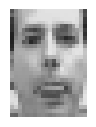

time: 52.1 ms (started: 2022-09-15 22:56:25 -07:00)


In [6]:
show_frey(data, 0)

## Pipeline

Transpose the data so the images are in the rows, not columns before proceeding:

In [7]:
data = data.T

time: 781 µs (started: 2022-09-15 22:56:25 -07:00)


In [11]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "frey",
    data=data,
    tags=["small", "image"],
    url="https://cs.nyu.edu/~roweis/data.html",
    verbose=True,
)

[23:00:57] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=842003;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=83382;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (1965, 560)                                                  ]8;id=408370;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=950958;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=190890;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=780392;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (1965, 560)                                 ]8;id=171054;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=553906;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=593532;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=713074;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (1965, 560)                                     ]8;id=921768;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=120924;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Checked for duplicates: found 0                                                 ]8;id=369460;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=909451;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=365578;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=566005;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=664155;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=924379;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Writing data for frey                                                           ]8;id=979137;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=671578;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[23:00:58] INFO     Calculating nearest neighbors                                                   ]8;id=444237;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=260100;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=551632;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=660891;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

[23:00:59] INFO     Calculating triplets                                                            ]8;id=216602;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=791380;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

[23:01:00] INFO     Writing csv format to triplets/frey.5.1337.idx.csv                              ]8;id=138437;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=980269;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

           INFO     Writing csv format to triplets/frey.5.1337.l2.csv                               ]8;id=627588;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=728858;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

           INFO     Writing numpy format to triplets/frey.5.1337.idx.npy                            ]8;id=18259;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=56519;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing numpy format to triplets/frey.5.1337.l2.npy                             ]8;id=274491;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=819357;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing pipeline result for frey                                                ]8;id=806416;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=914665;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 2.65 s (started: 2022-09-15 23:00:57 -07:00)
